In [2]:
from pyspark.sql import SparkSession
import pyarrow

# Create a Spark session
spark = SparkSession.builder.appName("kaggle_eegs").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")



24/02/01 20:23:15 WARN Utils: Your hostname, debianlab resolves to a loopback address: 127.0.1.1; using 192.168.1.155 instead (on interface enp2s0)
24/02/01 20:23:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/01 20:23:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/01 20:23:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50146)
Traceback (most recent call last):
  File "/usr/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/home/harraz/my_tensorflow/venv/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/harraz/my_tensorflow/venv/lib/python3.11/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/home/harraz/my_tensorflow/venv/lib/python3.

In [3]:
file_path = '/home/harraz/my_tensorflow/venv/eegs/training_data/train.csv'

# Read labels CSV file into a DataFrame
train_y = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
train_y.show(10)


24/02/01 20:23:44 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/02/01 20:23:44 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


+----------+----------+------------------------+--------------+------------------+--------------------------------+----------+----------+----------------+------------+--------+--------+---------+---------+----------+
|    eeg_id|eeg_sub_id|eeg_label_offset_seconds|spectrogram_id|spectrogram_sub_id|spectrogram_label_offset_seconds|  label_id|patient_id|expert_consensus|seizure_vote|lpd_vote|gpd_vote|lrda_vote|grda_vote|other_vote|
+----------+----------+------------------------+--------------+------------------+--------------------------------+----------+----------+----------------+------------+--------+--------+---------+---------+----------+
|1628180742|         0|                     0.0|        353733|                 0|                             0.0| 127492639|     42516|         Seizure|           3|       0|       0|        0|        0|         0|
|1628180742|         1|                     6.0|        353733|                 1|                             6.0|3887563113|     4

In [4]:
from pyspark.sql import DataFrame

file_path = '/home/harraz/my_tensorflow/venv/eegs/training_data/*.parquet'

# Read parquet file into a DataFrame
train_X = spark.read.parquet(file_path, inferSchema=False)


In [7]:
train_X.show(5)

+------+------+-----+-------+------+------+-------+------+------+-------+-------+------+------+------+------+------+------+-------+------+-------+
|   Fp1|    F3|   C3|     P3|    F7|    T3|     T5|    O1|    Fz|     Cz|     Pz|   Fp2|    F4|    C4|    P4|    F8|    T4|     T6|    O2|    EKG|
+------+------+-----+-------+------+------+-------+------+------+-------+-------+------+------+------+------+------+------+-------+------+-------+
| 567.1|363.72|72.92| -35.19|265.94|-40.32|  -99.6| 47.69|373.05| -77.65| -45.17|447.72|409.75|138.58|-72.06| 293.9|153.24| -65.26|  6.75|-573.45|
|518.53|332.84|40.11| -62.46|221.84|-78.58|-139.86|  7.73|335.34|-118.59| -79.48|393.69|375.36|103.85|-90.75|258.12|105.99|-106.26|-27.88|-345.45|
| 453.4|278.93| -8.8|-106.73|162.82|-126.0|-184.66|-37.95|280.84|-169.89|-123.68| 324.9|316.85| 51.24|-45.34| 196.9| 47.47|-141.96|-65.49|  59.09|
|523.89|345.43|52.39| -61.07|224.97|-61.89| -115.3| 25.22|344.91|-104.55| -58.75|404.53| 378.5|106.69|-54.09|246.21|10

In [65]:
from pyspark.sql.functions import when

train_Labels = train_y.withColumn('expert_consensus', when(train_y['expert_consensus'] == 'Seizure', 1).otherwise(0))
train_Labels = train_Labels.select(train_Labels.expert_consensus).limit(100000)
train_Labels.show(5)

+----------------+
|expert_consensus|
+----------------+
|               1|
|               1|
|               1|
|               1|
|               1|
+----------------+
only showing top 5 rows



In [40]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# List of feature columns
feature_columns = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

# Create a VectorAssembler
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled")
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled", handleInvalid="skip")

# Apply VectorAssembler to the training data
train_X_assembled = assembler.transform(train_X)

# Cast the features_assembled column to VectorUDT
train_X_assembled = train_X_assembled.withColumn("features_assembled", col("features_assembled").cast(VectorUDT()))

# Create a StandardScaler
scaler = StandardScaler(inputCol="features_assembled", outputCol="normalized_features", withStd=True, withMean=True)

# Fit the StandardScaler on the training data
scaler_model = scaler.fit(train_X_assembled)

# Transform the training data
train_X_scaled = scaler_model.transform(train_X_assembled)

# Display the scaled features
train_X_scaled.select("normalized_features").show(truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|normalized_features                                                                                                                                                                                                                                                                                                                                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------------------

In [41]:
# Write the DataFrame to a Parquet file
# train_X_scaled.write.parquet("/home/harraz/my_tensorflow/venv/eegs/training_data/train_X_scaled.parquet")


In [67]:
train_X_scaled = spark.read.parquet("/home/harraz/my_tensorflow/venv/eegs/training_data/train_X_scaled.parquet")
train_X_scaled = train_X_scaled.select('normalized_features').limit(100000)
train_X_scaled.printSchema()

root
 |-- normalized_features: vector (nullable = true)



In [68]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.ml.linalg import VectorUDT

# Assuming "normalized_features" is a VectorUDT
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Apply the UDF to convert "normalized_features" to an array
train_X_scaled = train_X_scaled.withColumn("normalized_features_array", vector_to_array_udf("normalized_features"))

train_X_scaled =train_X_scaled.drop('normalized_features')
# Now, you can use the array as needed, and potentially convert it to a NumPy array
train_X_scaled.show(3)


+-------------------------+
|normalized_features_array|
+-------------------------+
|     [0.32061088, 0.25...|
|     [0.28890824, 0.22...|
|     [0.24639647, 0.18...|
+-------------------------+
only showing top 3 rows



In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Assuming train_X_scaled_np and train_Labels are PySpark DataFrames
# Convert them directly to NumPy arrays
train_X_scaled_np = np.array(train_X_scaled.collect())
train_Labels_np = np.array(train_Labels.collect())

In [70]:
print(train_X_scaled_np.shape)
print(train_Labels_np.shape)

(100000, 1, 20)
(100000, 1)


In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
# build keras model with optimizer and 3 layer NN
def build_model():
  model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 20)),  # Adjust the input shape
    layers.Dense(300, activation=tf.nn.relu),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dense(1, activation=tf.nn.sigmoid)
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.05)

  # model.compile(loss='mse',
  #               optimizer=optimizer,
  #               metrics=['mse','mae'])
  
  model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.SGD(0.4),
              metrics=['accuracy'])

  return model

model=build_model()
model.summary()
# keras.utils.plot_model(model, "hd_model.png", show_shapes=True)

EPOCHS = 300
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
history = model.fit(
    x=train_X_scaled_np, y=train_Labels_np, batch_size=None, epochs=EPOCHS, verbose=1,
    callbacks=[early_stop], validation_split=0.2, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=True
)


2.15.0
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
 dense_24 (Dense)            (None, 300)               6300      
                                                                 
 dense_25 (Dense)            (None, 200)               60200     
                                                                 
 dense_26 (Dense)            (None, 1)                 201       
                                                                 
Total params: 66701 (260.55 KB)
Trainable params: 66701 (260.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
2500/2500 [==============================] - 28s 11ms/step - loss: 0.1981 - accuracy: 0.8033 - val_loss: 0.1744 - val_accuracy: 0

24/02/02 17:18:17 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 3597885 ms exceeds timeout 120000 ms
24/02/02 17:18:17 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/02 17:18:25 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

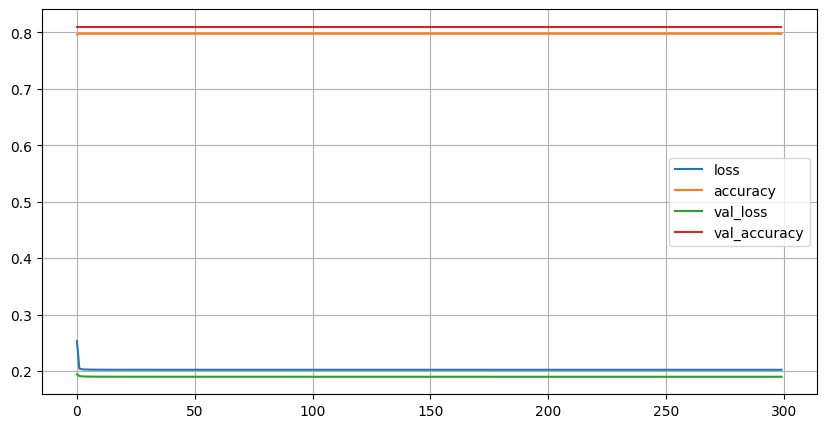

In [ ]:
# To plot pretty figures
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
# plt.xticks(np.arange(0, 100, 1))
plt.show()

In [ ]:
# from pyspark.sql.types import StructType, StructField, DoubleType

# # Define the schema struct with DoubleType
# schema_struct_double = StructType([
#     StructField("Fp1", DoubleType(), True),
#     StructField("F3", DoubleType(), True),
#     StructField("C3", DoubleType(), True),
#     StructField("P3", DoubleType(), True),
#     StructField("F7", DoubleType(), True),
#     StructField("T3", DoubleType(), True),
#     StructField("T5", DoubleType(), True),
#     StructField("O1", DoubleType(), True),
#     StructField("Fz", DoubleType(), True),
#     StructField("Cz", DoubleType(), True),
#     StructField("Pz", DoubleType(), True),
#     StructField("Fp2", DoubleType(), True),
#     StructField("F4", DoubleType(), True),
#     StructField("C4", DoubleType(), True),
#     StructField("P4", DoubleType(), True),
#     StructField("F8", DoubleType(), True),
#     StructField("T4", DoubleType(), True),
#     StructField("T6", DoubleType(), True),
#     StructField("O2", DoubleType(), True),
#     StructField("EKG", DoubleType(), True)
# ])
# # Use the VectorAssembler with explicit input and output columns
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# train_X = assembler.transform(train_X)
